In [23]:
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from imutils import paths
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import cv2
import xml.etree.ElementTree as et
import pandas as pd
import math

pathOfImages = 'C:/Users/hp/Jupyter Notebook Work/Practicum - Face Mask Detection/Dataset/images'
pathOfAnnotations = 'C:/Users/hp/Jupyter Notebook Work/Practicum - Face Mask Detection/Dataset/annotations'

In [24]:
image_path= pathlib.Path(pathOfImages)
annot_path = pathlib.Path(pathOfAnnotations)
image_directories = sorted(glob.glob(os.path.join(image_path,"*.png")))

In [25]:
face_list = []

def compare_dataframes():
    classes = ["without_mask","mask_weared_incorrect","with_mask"]
    
    for idx,image in enumerate(image_directories): # Extract data into respective label folders

        im_name = image[62:]
        img  = cv2.imread(image)
        
        X,Y = dataframe["Dimensions"][idx] #scale to dimension
        cv2.resize(img,(int(X),int(Y)))
        
        face_count = 0
        for obj in dataframe.columns[3:]: #find the face in each object
            info = dataframe[obj][idx]
            
            if info!=0:
                label = info[0]
                
                info[0] = info[0].replace(str(label), str(classes.index(label))) # first element of the "object" cell - replace label with the index from classes list
                info=[int(each) for each in info]
                face = img[info[2]:info[4],info[1]:info[3]]
                
                if((info[3]-info[1]>15) and (info[4]-info[2])>15): # Set a minimum size of 15 x 15 for face detection to improve model performance
                    face_count += 1

        face_list.append([im_name, face_count])
    return face_list
    print("Comparing Completed.")

In [26]:
# face detector to locate faces in an image at a given confidence minimum

def detect(img, imageId, confidence_min):
    image = cv2.imread(img)
    (h, w) = image.shape[:2]
    
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0)) # blob takes in the image, scale factor, output size, and RGB means for subtraction. ImageNet means are used as the default. 
    net.setInput(blob)
    out = net.forward()

    for i in range(out.shape[2]):
        
        confidence = out[0, 0, i, 2]
        
        if confidence >= confidence_min:
            box = out[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            
            (startX, startY) = (max(0, startX), max(0, startY)) # ensure the bounding boxes fall within the dimensions of the frame
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            
            face = image[startY:endY, startX:endX] # extract the face ROI, convert it from BGR to RGB channel, resize, and preprocess
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)
            
            
            mask_weared_incorrect, with_mask, without_mask = model.predict(face)[0] # pass the face through the model to determine class
            
            if max([mask_weared_incorrect, with_mask, without_mask]) == with_mask:
                label = 'with_mask'
                color = (0, 255, 0)
            elif max([mask_weared_incorrect, with_mask, without_mask]) == without_mask:
                label = 'without_mask'
                color = (0, 0, 255)
            else:
                label = 'mask_worn_incorrectly'
                color = (255, 0, 0)
                
            
            label = "{}: {:.2f}%".format(label, max([mask_weared_incorrect, with_mask, without_mask]) * 100)
            
            
            cv2.putText(image, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

            detections.append([img[62:], label, color, startX, startY, endX, endY])
            
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
            plt.grid(None)
            

# Reference - https://github.com/opencv/opencv/blob/master/modules/dnn/misc/face_detector_accuracy.py

In [27]:
detections = []
def detect_all_images():
    
    for idx,image in enumerate(image_directories):

        imageId = idx
        try:
            detect(image, imageId, 0.3)
        except:
            pass
#             print(f'error with image {image}')
            

In [28]:
def diff_analysis():
    detections_df = pd.DataFrame(detections, columns=['image', 'label', 'color', 'startX', 'startY', 'endX', 'endY'])
    detection_count = pd.DataFrame(detections_df.groupby('image')['label'].count())
    face_detection_count_df = pd.merge(face_df, detection_count, on='image', how = 'left')
    face_detection_count_df.columns = ['image', 'face_count', 'detected']
    face_detection_count_df.fillna(0, inplace=True)
    face_detection_count_df['diff'] = face_detection_count_df['face_count'] - face_detection_count_df['detected']
    return face_detection_count_df

Loading face mask detector model...
Loading Completed.
1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 47ms/step


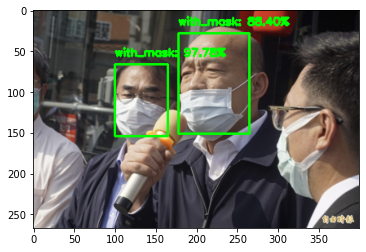

In [29]:
dataframe = pd.read_pickle('1.1.annotated_image_dataframe.pkl')

face_list = compare_dataframes()

face_df = pd.DataFrame(face_list, columns=['image', 'face_count'])
face_df.to_pickle('4.1.openCV_comparison_dataframe.pkl')

prototxtPath = os.path.sep.join(['./opencv_face_detector/', "deploy.prototxt"]) # read in face detector and weights
weightsPath = os.path.sep.join(['./opencv_face_detector/', "res10_300x300_ssd_iter_140000.caffemodel"])

net = cv2.dnn.readNet(prototxtPath, weightsPath)


print("Loading face mask detector model...") # load the face mask detector model
model = load_model('2.1.mobilev2net_detector.h5')
print('Loading Completed.')

detect_all_images()

face_detection_count_df = diff_analysis()

In [30]:
detections_df.head()

,image,label,color,startX,startY,endX,endY
0,ion\Dataset\images\maksssksksss0.png,without_mask: 95.53%,"(0, 0, 255)",322,78,362,143
1,ion\Dataset\images\maksssksksss0.png,with_mask: 54.85%,"(0, 255, 0)",75,101,117,139
2,ion\Dataset\images\maksssksksss1.png,with_mask: 87.55%,"(0, 255, 0)",76,45,111,92
3,ion\Dataset\images\maksssksksss1.png,with_mask: 99.51%,"(0, 255, 0)",223,27,259,71
4,ion\Dataset\images\maksssksksss1.png,with_mask: 99.68%,"(0, 255, 0)",319,26,352,67


In [31]:
face_detection_count_df.sort_values('diff', ascending=False)

,image,face_count,detected,diff
468,ion\Dataset\images\maksssksksss52.png,28,9.0,19.0
219,ion\Dataset\images\maksssksksss296.png,31,13.0,18.0
170,ion\Dataset\images\maksssksksss251.png,24,6.0,18.0
180,ion\Dataset\images\maksssksksss260.png,21,7.0,14.0
773,ion\Dataset\images\maksssksksss795.png,21,10.0,11.0
...,...,...,...,...
386,ion\Dataset\images\maksssksksss446.png,1,2.0,-1.0
207,ion\Dataset\images\maksssksksss285.png,1,2.0,-1.0
794,ion\Dataset\images\maksssksksss813.png,1,3.0,-2.0
107,ion\Dataset\images\maksssksksss195.png,1,3.0,-2.0


In [32]:
face_detection_count_df[face_detection_count_df['diff'] > 0].sum()

image         ion\Dataset\images\maksssksksss0.pngion\Datase...
face_count                                                 2156
detected                                                  970.0
diff                                                     1186.0
dtype: object

In [33]:
face_detection_count_df[face_detection_count_df['diff'] < 0].sum()

image         ion\Dataset\images\maksssksksss101.pngion\Data...
face_count                                                   58
detected                                                  106.0
diff                                                      -48.0
dtype: object